In [1]:
from heron import data
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
wine_txt = np.genfromtxt("../data/winequality-red.csv", delimiter=";",skip_header=1)

   1 - fixed acidity
   2 - volatile acidity
   3 - citric acid
   4 - residual sugar
   5 - chlorides
   6 - free sulfur dioxide
   7 - total sulfur dioxide
   8 - density
   9 - pH
   10 - sulphates
   11 - alcohol
   Output variable (based on sensory data): 
   12 - quality (score between 0 and 10)

In [4]:
wine = data.Data(wine_txt[:-20, :-1], wine_txt[:-20,-1],              
                     target_names = ["Fixed Acidity", "Volatile Acidity", 
                                     "Citric Acid", "Residual Sugar", 
                                     "Chlorides", "Free Sulphur diox", 
                                     "Total sulphur diox", "Density",
                                        "pH", "Sulphates", "Alcohol"],
                      label_names = ["Quality"]   )

/home/daniel/.virtualenvs/heron/local/lib/python2.7/site-packages/heron-0.1.0-py2.7.egg/heron/data.py:50: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


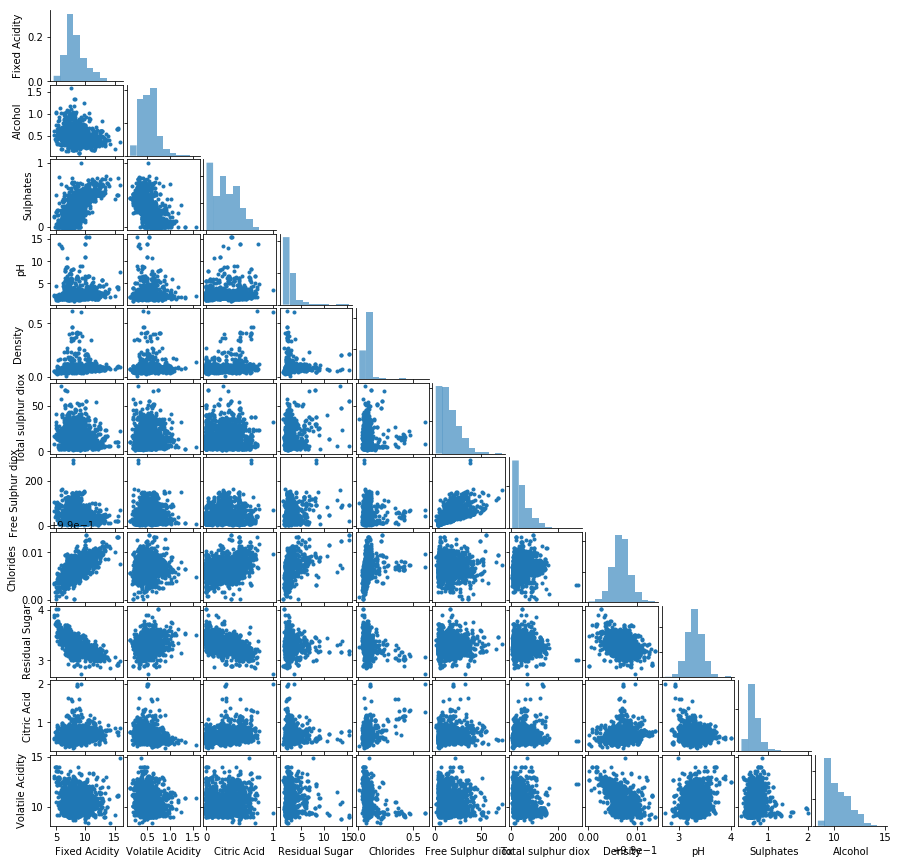

In [5]:
from heron import corner
corner.corner(wine, figsize=(15,15))

In [12]:
from heron import regression
from heron import kernels
gp = regression.Regressor(wine, kernel=kernels.SquaredExponential(ndim=11))

In [13]:
from scipy.optimize import minimize

In [14]:
def nll(p):
    p[0] = 1
    gp.set_hyperparameters(p)
    ll = gp.loglikelihood()
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    p[0] = 1
    gp.set_hyperparameters(p)
    return -gp.grad_loglikelihood()

In [ ]:
x0 = [0.9]*12
x0[0] = 1
res = minimize(nll, x0, method='BFGS', jac=grad_nll ,options={'disp': True})

/home/daniel/.virtualenvs/heron/local/lib/python2.7/site-packages/heron-0.1.0-py2.7.egg/heron/kernels.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


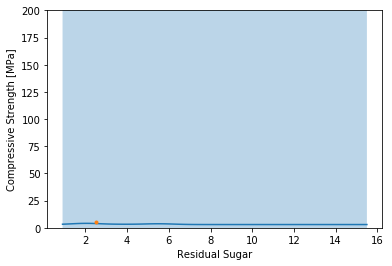

In [9]:
i = 3
test_point = 0
new_point = np.atleast_2d(wine.test_targets[test_point])
new_point = np.tile(new_point, (100,1))
new_point[:,i] = np.linspace(0,1,100)
pred = gp.prediction(new_point)
x = gp.training_object.denormalise(new_point, gp.training_object.targets_scale)[:,i]
plt.plot(x, pred[0])
plt.ylim([0,200])
#plt.xlim([0,gp.training_object.targets_scale[1][i]])
plt.xlabel(gp.training_object.target_names[i])
#plt.xlabel(r"Superplasticiser [kg / m$^3$]")
plt.ylabel("Compressive Strength [MPa]")
err = np.diag(pred[1])
err = gp.training_object.denormalise(err, gp.training_object.labels_scale)
err *= 1.96
plt.fill_between(x, pred[0] - err, pred[0] + err , alpha = 0.3)
plt.plot(gp.training_object.denormalise(wine.test_targets[test_point], gp.training_object.targets_scale)[i], 
        gp.training_object.denormalise(wine.test_labels, gp.training_object.labels_scale)[test_point], '.')
#plt.savefig('superplasticiser.png', dpi=300)